In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [16]:
class ConvLSTMNetwork(nn.Module):
    def __init__(self, num_frames, num_classes_rotation, num_classes_angle):
        super(ConvLSTMNetwork, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=2)
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=2)
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=11, padding=5)
        # Dimensionality reduction layer
        self.intermediate_fc = nn.Linear(im_fc_in, im_fc_out)
        # Fully Connected Layers for classification
        self.fc_rotation = nn.Linear(fc_in, num_classes_rotation)
        self.fc_angle = nn.Linear(fc_in, num_classes_angle)
        # Activation Functions
        self.relu = nn.ReLU()
    def forward(self, x):
        # batch_size=4, num_frames=5, channels=1, height=128, width=128
        batch_size, num_frames, channels, height, width = x.size()
        # Process each frame through convolutional layers
        conv_outputs = []
        for t in range(num_frames):
            # Extracting frame t from each stack in the batch
            frame = x[:, t, :, :, :]
            # Pass the frame through convolutional layers
            out = self.relu(self.conv1(frame))
            out = self.relu(self.conv2(out))
            out = self.relu(self.conv3(out))
            # Flatten the output for FC layers
            out = out.view(batch_size, -1) 
            #print(f"conv2 output:{out.shape}")
            # Append output to list
            conv_outputs.append(out)
        # Concatenate the outputs along a specific dimension (e.g., 1)
        x = torch.cat(conv_outputs, dim=1)
        # Fully Connected Layers for classification
        output_rotation = self.fc_rotation(x)
        output_angle = self.fc_angle(x)

        return output_rotation, output_angle

In [17]:
# Load the trained model
model = torch.load('models/looped_2dcnn_3layer.pt')
model.eval()  # Set the model to evaluation mode

ConvLSTMNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(4, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (intermediate_fc): Linear(in_features=131072, out_features=512, bias=True)
  (fc_rotation): Linear(in_features=655360, out_features=2, bias=True)
  (fc_angle): Linear(in_features=655360, out_features=36, bias=True)
  (relu): ReLU()
)

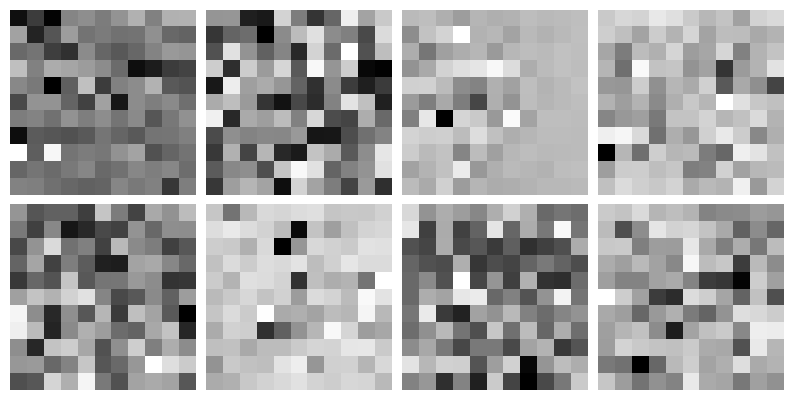

In [25]:
# Function to plot slices of 3D kernels
def plot_3d_kernels(tensor, slice_num=0, num_cols=4):
    if not tensor.ndim == 4:
        raise Exception("Assumes a 4D tensor")
    
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(num_kernels):
        ax = fig.add_subplot(4, 4, i + 1)
        npimg = np.array(tensor[i, slice_num, :, :].cpu().numpy(), np.float32)
        npimg = (npimg - np.min(npimg)) / (np.max(npimg) - np.min(npimg))
        ax.imshow(npimg, cmap='gray')
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Select a layer and a slice number
conv_layer = model.conv3.weight.data
slice_num = 2 # You can change this to visualize different slices

# Visualize the kernels
plot_3d_kernels(conv_layer, slice_num=slice_num)